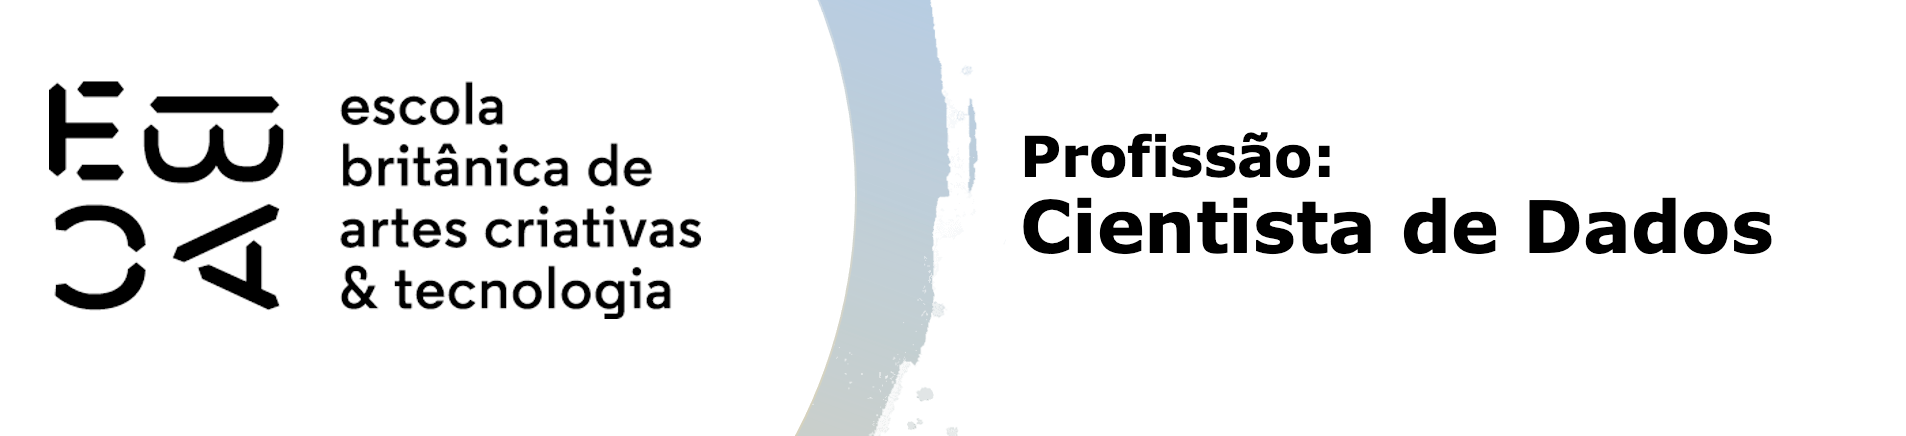

# Regressão III - Tarefa

In [3]:
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import numpy             as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble        import GradientBoostingRegressor



from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api                          as sm

In [4]:
df = pd.read_csv('./Dados/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


### Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [6]:
# Conferindo valores faltantes
df.isnull().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [7]:
# Transformado valores faltantes na media
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median())
df.isnull().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [9]:
# Conferindo os meses.
df.index.value_counts()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [10]:
# Somente os ultimos 3 meses.
ultimos_3_indices = df.index.unique()[-3:] 
df_3 = df[df.index.isin(ultimos_3_indices)]  
df_3.index.value_counts()

data_ref
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [12]:
# Dropando o Index (data_ref)
df_3.reset_index(drop=True)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,6.046575,2.0,2137.61
1,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35
2,16279,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47
3,8158,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82
4,9356,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40
149996,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,6.046575,2.0,4084.37
149997,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66
149998,3024,F,S,S,1,Empresário,Superior completo,União,Casa,28,8.219178,3.0,9159.49


In [13]:
# Separando a variável dependente (y) e as variáveis independentes (X)
X = df_3.drop(columns=['renda'])
y = df_3['renda']

# Definindo as colunas categóricas
categorico = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia']

# Criando as variáveis dummy 
X_categorico = pd.get_dummies(X[categorico], drop_first=True) 

# Concatenando as variáveis dummy de volta ao DataFrame
X = pd.concat([X.drop(columns=categorico), X_categorico], axis=1)

# Treino, teste e fit.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# R² e R² ajustado
n = X_test.shape[0]  # Número de observações no teste
p = X_test.shape[1]  # Número de variáveis preditoras

r2 = r2_score(y_test, y_pred)
r2_ajustado = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R²: {r2:.4f}")
print(f"R² Ajustado: {r2_ajustado:.4f}")

R²: 0.3073
R² Ajustado: 0.3069


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [15]:
df_3 = df_3.copy()

# Agrupar por categoria e calcular as métricas
df_3.loc[:, 'categoria_tempo_emprego'] = pd.qcut(df_3['tempo_emprego'], 20, labels=False, duplicates='drop')
df_3.loc[:, 'log_renda'] = np.log(df_3['renda'])  # Criando a coluna de log da renda

# Agrupar por categoria e calcular as métricas
perfil_categoria = df_3.groupby('categoria_tempo_emprego').agg(
    quantidade=('tempo_emprego', 'size'),
    media_log_renda=('log_renda', 'mean'),
    media_tempo_emprego=('tempo_emprego', 'mean')
).reset_index()

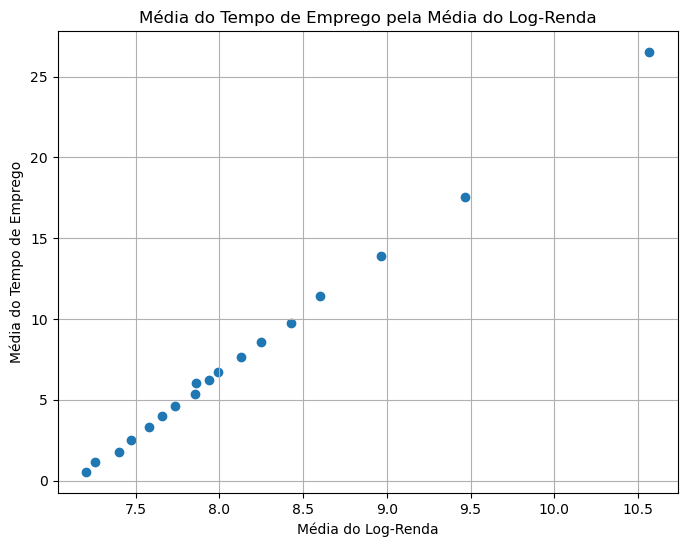

    categoria_tempo_emprego  quantidade  media_log_renda  media_tempo_emprego
0                         0        7601         7.202604             0.520903
1                         1        7464         7.257080             1.134215
2                         2        7459         7.401755             1.790156
3                         3        7511         7.472002             2.514075
4                         4        7507         7.578685             3.299975
5                         5        7545         7.660521             3.994033
6                         6        7420         7.734648             4.624617
7                         7        7509         7.857738             5.370319
8                         8       27558         7.859378             6.035001
9                         9        2449         7.936661             6.209752
10                       10        7484         7.995064             6.735463
11                       11        7562         8.131742        

In [16]:
# Gráfico de média do tempo de emprego pela média do log-renda
plt.figure(figsize=(8, 6))
plt.scatter(perfil_categoria['media_log_renda'], perfil_categoria['media_tempo_emprego'])
plt.title('Média do Tempo de Emprego pela Média do Log-Renda')
plt.xlabel('Média do Log-Renda')
plt.ylabel('Média do Tempo de Emprego')
plt.grid(True)
plt.show()

# Exibir a tabela de perfil
print(perfil_categoria)



### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [18]:
X = df_3[['tempo_emprego']]
y = df_3['renda']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=27)

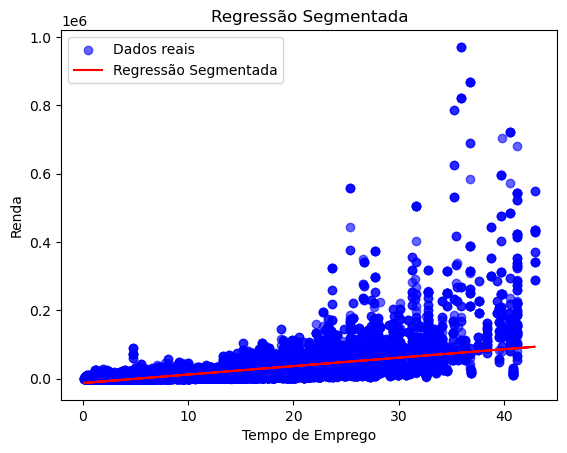

In [19]:
# Segmentação dos dados
threshold = 2 
X_segmentado = X_train.copy()
X_segmentado['segmento'] = (X_segmentado['tempo_emprego'] > threshold).astype(int)

# Ajustando um modelo linear para cada segmento
modelo_segmentado = LinearRegression()
modelo_segmentado.fit(X_segmentado[['tempo_emprego']], y_train)  
modelo_segmentado.fit(X_segmentado[X_segmentado['segmento'] == 1][['tempo_emprego']], y_train[X_segmentado['segmento'] == 1])

# Prevendo para o conjunto de teste
y_pred_segmentado = modelo_segmentado.predict(X_test)

# Calculando R² ajustado
r2_segmentado = 1 - (1 - r2_score(y_test, y_pred_segmentado)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)


# Plotando Regressão Segmentada
plt.scatter(X_train, y_train, color='blue', label='Dados reais', alpha = 0.6)
plt.plot(X_train, modelo_segmentado.predict(X_train[['tempo_emprego']]), color='red', label='Regressão Segmentada')
plt.title('Regressão Segmentada')
plt.xlabel('Tempo de Emprego')
plt.ylabel('Renda')
plt.legend()

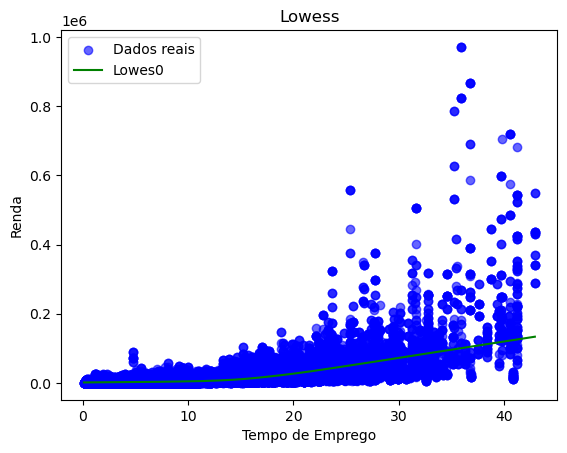

In [20]:
# Ajustando o modelo Lowess
lowess_model = lowess(y_train, X_train['tempo_emprego'], frac=0.2) 

# Prevendo com Lowess 
y_pred_lowess = lowess_model[:, 1]  # Valores suavizados para y_train

# R² ajustado
r2_lowess = 1 - (1 - r2_score(y_train, y_pred_lowess)) * (len(y_train) - 1) / (len(y_train) - 1 - 1)

# Plotando Lowess
plt.scatter(X_train, y_train, color='blue', label='Dados reais', alpha = 0.6)
plt.plot(lowess_model[:, 0], lowess_model[:, 1], color='green', label='Lowes0')
plt.title('Lowess')
plt.xlabel('Tempo de Emprego')
plt.ylabel('Renda')
plt.legend()

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [22]:
print(f"R² Ajustado - Linear: {r2_ajustado:.4f}")
print(f"R^2 Ajustado - Regressão Segmentada: {r2_segmentado:.4f}")
print(f"R^2 Ajustado - Lowess: {r2_lowess:.4f}")

R² Ajustado - Linear: 0.3069
R^2 Ajustado - Regressão Segmentada: 0.2916
R^2 Ajustado - Lowess: -0.3061


* O **modelo linear** é o melhor até agora, com um **R² Ajustado** de **0.4764.**

* A **regressão segmentada** precisa de ajustes para melhorar seu desempenho.

* O **Lowess** não está funcionando bem e precisa ser reavaliado ou substituído.

* Acredito que a escolha dos modelos acima não foi uma das melhores devido a natureza linear do *dataframe*, para isso, realizarei um *gradientboost* por achar que é uma opção melhor.

In [24]:
%%time

X = df_3.drop(columns=['renda'])
y = df_3['renda']

# Criando variáveis dummy para colunas categóricas

categorico = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia']
X_categorico = pd.get_dummies(X[categorico], drop_first=True)
X = pd.concat([X.drop(columns=categorico), X_categorico], axis=1)

from sklearn.model_selection import RandomizedSearchCV

# Buscando os melhores hiperparâmetros
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=27),
    param_distributions=param_dist,
    scoring='r2',
    n_jobs=-1,  # Usar todos os núcleos disponíveis (para não ficar 15 minutos esperando)
    random_state=27
)

# Executando a busca
random_search.fit(X_train, y_train)

# Resultados
print(f"Melhores parâmetros: {random_search.best_params_}")
print(f"Melhor R²: {random_search.best_score_:.4f}")

Melhores parâmetros: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.2}
Melhor R²: 0.6682
CPU times: total: 22.9 s
Wall time: 1min 12s


In [25]:
%%time

# Dividindo os dados em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=27)

# Dividindo o conjunto de treino em treino e validação (70% treino, 30% validação)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=72)

# Parametros (vistos acima)
modelo_gb = GradientBoostingRegressor(
    n_estimators=150,  
    learning_rate=0.2,  
    max_depth=5,  
    random_state=27
)
modelo_gb.fit(X_train, y_train)

# Fazendo previsões
y_pred_gb = modelo_gb.predict(X_test)

# Calculando R² e R² ajustado
n = X_test.shape[0]  # Número de observações no teste
p = X_test.shape[1]  # Número de variáveis preditoras

r2_gb = r2_score(y_test, y_pred_gb)
r2_ajustado_gb = 1 - (1 - r2_gb) * (n - 1) / (n - p - 1)

print(f"R² - Gradient Boosting: {r2_gb:.4f}")
print(f"R² Ajustado - Gradient Boosting: {r2_ajustado_gb:.4f}")

R² - Gradient Boosting: 0.9998
R² Ajustado - Gradient Boosting: 0.9998
CPU times: total: 30.1 s
Wall time: 30.2 s
